In [1]:
import release
import diffusionHB
import uptake

**Geometric parameter**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

D = 0.7 # Diffusion coeficient [um2 /ms].
B = 0.5 # Radious of the cilinder [um].
L = 1.1 # Longitud of the cilinder [um]. 
n = 12  # Number of radial compartments.
m = 10  # Number of longitudinal compartments.
dr = (B / n) # Distance betweet two radial compartments [um].
dl = L / m # Distance betweet two longitudinal compartments [um].
dr2, dl2 = dr * dr, dl * dl
dt = dr2 * dl2 / (2 * D * (dr2 + dl2))


**Release rate parameters**

In [3]:
R = 3000 # Maximun release tase
t_on = 1.5 # Time constant of turn on permeability [ms]
t_off = 2 # Time constant of turn off permeability [ms]
L=5 
M=1

**Uptake parameters**

In [4]:
kd = 5
vmax = 10

**Binding parameters**

In [5]:
Local_concentration_T = 140 
T_av = Local_concentration_T  / ( m * ( n - 2 ) )
sites_T0 = np.zeros( ( n, m ) )
sites_T0[2:n,0:m] = ( Local_concentration_T ) / ( m * ( n - 2 ) )
Total_T =np.zeros((n, m))
Total_T[2:n,0:m] = 0.94 / ( m * ( n - 2 ) )
sites_TC = np.empty( (n, m ) )
sites_TC0 = np.zeros( ( n, m ))
sites_TC0[2:n,0:m] = 0.06 / ( ( n - 2 ) * m )
sites_T = np.empty( ( n, m ) )

k_on_Tr = 0.12  
k_off_Tr = 0.12  


def CaT(c,tr,ctr,dt):
    return( + ( k_on_Tr * c * ( T_av - ctr ) ) - ( k_off_Tr * ctr ) ) * dt  
 

def Tr(c,tr,ctr,dt):
    return ( - ( k_on_Tr * c * ( T_av - ctr ) ) + ( k_off_Tr * ctr ) ) * dt 



In [6]:
Local_concentration_P = 940 
P_av = Local_concentration_P  / ( m * ( n - 1 ) ) #0.02 *
sites_P0 = np.zeros((n, m))
sites_P0[1:n,0:m] = ( 0.02 * Local_concentration_P ) / ( m * ( n - 1 ) ) #0.02 *
Total_P=np.zeros((n, m))
Total_P[1:n,0:m] = 100 / ( m * ( n - 1 ) )
sites_PC = np.empty((n, m))
sites_PC0 = np.zeros((n, m))
sites_PC0[1:n,0:m] = ( 0.28 * 940 ) / ( ( n - 1 ) * m ) # ( 0.28 * 940 )
sites_P = np.empty(( n, m ))

k_on_Par = 2.5 *( 10**-1 )  #/((n-1)*m)
k_off_Par = 0.1 * ( 10 **-3 ) # /((n-1)*m)

def CaP(c,p,cp,mgp,dt):
    return( + ( k_on_Par * c * ( P_av - mgp  - cp ) ) - ( k_off_Par * cp ) ) * dt 
 
def Par(c,p,cp,mgp,dt):
    return ( - ( k_on_Par * c * ( P_av - mgp  - cp ) ) + ( k_off_Par * cp ) ) * dt

def Ca(c,p,cp,tr,ctr,mgp,dt):
    return ( - ( k_on_Par * c * ( P_av - mgp - cp ) ) + ( k_off_Par * cp ) - ( k_on_Tr * c * ( T_av - ctr ) ) + ( k_off_Tr * ctr ) ) * dt


In [7]:
Local_concentration_Mg = 3300 
Mg_av = (Local_concentration_Mg ) / ( m * ( n-1 ) )
sites_Mg0 = np.zeros((n, m))
sites_Mg0[1:n,0:m] = ( 0.30 * Local_concentration_Mg ) / ( m * ( n-1 ) )
sites_PMg = np.empty((n, m))
sites_PMg0 = np.zeros((n, m))
sites_PMg0[1:n,0:m] =( 0.70  * 940 ) / ( ( n - 1 ) * m ) 
sites_Mg = np.empty((n, m))

k_on_Mg = 6.6 *( 10**-5 )  #/((n-1)*m)
k_off_Mg = 6 * ( 10**-3 )  #/((n-1)*m)

def MgP(mg,p,mgp,cp,dt):
    return( + (k_on_Mg * mg * ( P_av - mgp  - cp) ) - ( k_off_Mg * mgp ) ) * dt
 

def ParMg(mg,p,mgp,cp,dt):
    return ( - ( k_on_Mg * mg * ( P_av - mgp  - cp) ) + ( k_off_Mg * mgp ) ) * dt 

def Mg(mg,p,mgp,cp,dt):
    return ( - ( k_on_Mg * mg * ( P_av - mgp - cp ) ) + ( k_off_Mg * mgp ) ) * dt 


** Inicial conditions **

In [8]:
u0 = np.zeros([n,m]) 
u0[0,0] = 1500 
u0[1:n,0:m] = 0.06 / (m*(n-1))
u = np.empty((n, m))

**Main program**

In [9]:
#dt = 0.001
nsteps = 100000
us={}
sites_TCs={}
sites_PCs={}

for nstep in range(nsteps):
    
    # save matrix
    
    us[nstep]=u0.copy()
    sites_TCs[nstep]=sites_TC0.copy()
    sites_PCs[nstep]=sites_PC0.copy()
    
    # release

    u[1,0]= u0[1,0] + (dt*release.Release_rate(nstep*dt,R,t_on,t_off,L,M))
    u[0,0]= u0[0,0] - (dt*release.Release_rate(nstep*dt,R,t_on,t_off,L,M))

    # uptake
    
    for j in range(m):

        u[0,j]= u0[0,j] + (dt*uptake.Pump_rate(nstep*dt,u0[1,j],kd,vmax))
        u[1,j]= u0[1,j] - (dt*uptake.Pump_rate(nstep*dt,u0[1,j],kd,vmax))
        

    
    # binding


     # troponina
        
    sites_TC = sites_TC0 + CaT(u0,sites_T0,sites_TC0,dt)    
    sites_T = sites_T0 + Tr(u0,sites_T0,sites_TC0,dt)
    
    # parvalbumina
    
    #sites_P = sites_P0 + Par(u0,sites_P0,sites_PC0,sites_PMg0,dt) + ParMg(sites_Mg0,sites_P0,sites_PMg0,sites_PC0,dt) 

    sites_PC = sites_PC0 + CaP(u0,sites_P0,sites_PC0,sites_PMg0,dt)
    #sites_P0 = sites_P0 + Par(u0,sites_P0,sites_PC0,sites_PMg0,dt)    
        
    # magnesium
        
    sites_PMg = sites_PMg0 + MgP(sites_Mg0,sites_P0,sites_PMg0,sites_PC0,dt)   
    sites_Mg = sites_Mg0 + Mg(sites_Mg0,sites_P0,sites_PMg0,sites_PC0,dt)

    
    # calcium
    
    u0 = u0 + Ca(u0,sites_P0,sites_PC0,sites_T0,sites_TC0,sites_PMg0,dt)

    sites_TC0=sites_TC 
    sites_T0=sites_T
    sites_PC0=sites_PC
    sites_PMg0=sites_PMg
    sites_Mg0=sites_Mg
    sites_P0=sites_P
    
    # diffusion

    u0, u = diffusionHB.do_timestep(u0, u, 0.7,dl,dr,dt,m,n)  

    # result

    u=u0
   

** Results **

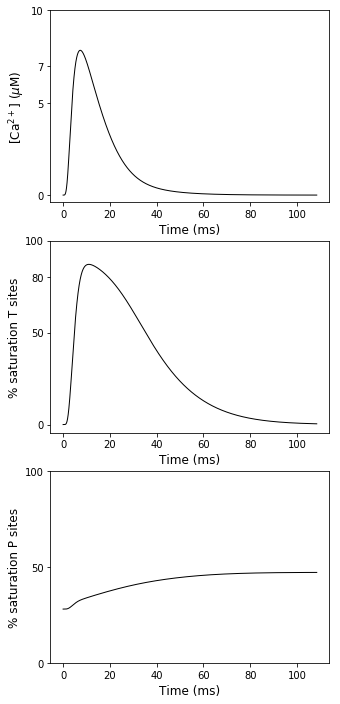

In [10]:
fig3 = plt.figure(figsize=(5,12))

ax1 = fig3.add_subplot(3, 1, 1)

ms_c=[]
time=[]
for nstep in range(nsteps):
    ms_c.append(np.mean(us[nstep][1:n,0:m]))
    time.append(nstep*dt)
ax1.plot(time,ms_c,color='black',linewidth=1.0)
ax1.set_yticks([0, 5, 7, 10])
ax1.set_ylabel(r'[Ca$^{2+}]$ ($\mu$M)',fontsize=12)
ax1.set_xlabel(r'Time (ms)',fontsize=12)


ax2 = fig3.add_subplot(3, 1, 2)

ms_c=[]
time=[]
for nstep in range(nsteps):
    ms_c.append(100*(np.sum(sites_TCs[nstep][2:n,0:m])/140))
    time.append(nstep*dt)
ax2.plot(time,ms_c,color='black',linewidth=1.0)
ax2.set_yticks([0, 50, 80, 100])
ax2.set_xlabel(r'Time (ms)',fontsize=12)
ax2.set_ylabel(r'% saturation T sites',fontsize=12)

ax3 = fig3.add_subplot(3, 1, 3)

ms_c=[]
time=[]
for nstep in range(nsteps):
    ms_c.append(100*(np.sum(sites_PCs[nstep][1:n,0:m])/940))
    time.append(nstep*dt)
ax3.plot(time,ms_c,color='black',linewidth=1.0)
ax3.set_yticks([0, 50, 100])
ax3.set_xlabel(r'Time (ms)',fontsize=12)
ax3.set_ylabel(r'% saturation P sites',fontsize=12)

plt.show() 

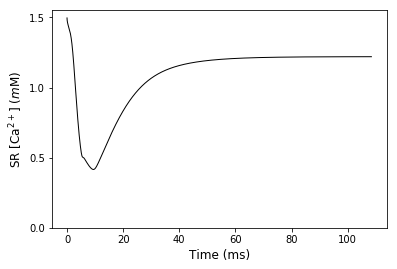

In [12]:
ms_c=[]
time=[]
for nstep in range(nsteps):
    ms_c.append(np.sum(us[nstep][0,0:m]/1000))
    time.append(nstep*dt)
plt.plot(time,ms_c,color='black',linewidth=1.0)
plt.savefig('Figuredt.pdf')
plt.yticks([0, 0.5, 1.0, 1.5])
plt.ylabel(r'SR [Ca$^{2+}]$ ($m$M)',fontsize=12,rotation=90)
plt.xlabel(r'Time (ms)',fontsize=12)
plt.show()

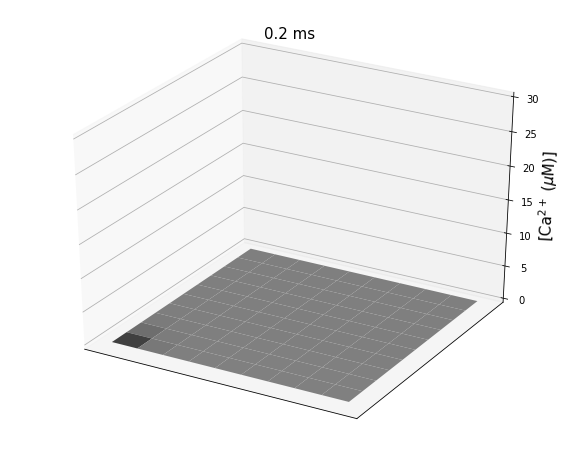

In [32]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

nstep=200
lon = np.arange(0,m, 1)
lon2=np.zeros([n-1,m]) + lon
rad = np.arange(0,n-1, 1)
rad2 = np.zeros([m,n-1]) + rad
z=us[nstep][1:n,0:m]
rad2=np.rot90(rad2,-1)
rad2.shape

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_surface(lon2, rad2, z,rstride=1, cstride=1,color='gray',vmin=0)
ax.set_title('{:.1f} ms'.format(nstep*dt),fontsize=15)
ax.set_zlim(0, 30)
ax.set_zlabel(r'[Ca$^{2+}$ ($\mu$M)]',fontsize=15,rotation=180)
ax.set_xticks([])#([0, 9])
ax.set_xticklabels([])#(['z', 'm'])
ax.set_yticks([])
ax.set_yticklabels([])

plt.show()

In [35]:
for i in range(0,20000,100):
    nstep=i
    lon = np.arange(0,m, 1)
    lon2=np.zeros([n-1,m]) + lon
    rad = np.arange(0,n-1, 1)
    rad2 = np.zeros([m,n-1]) + rad
    z=us[nstep][1:n,0:m]
    rad2=np.rot90(rad2,-1)
    rad2.shape

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a basic wireframe.
    ax.plot_surface(lon2, rad2, z,rstride=1, cstride=1,color='gray',vmin=0)
    ax.set_title('{:.1f} ms'.format(nstep*dt),fontsize=15)
    ax.set_zlim(0, 30)
    ax.set_zlabel(r'[Ca$^{2+}$ ($\mu$M)]',fontsize=15,rotation=90)
    ax.set_xticks([])#([0, 9])
    ax.set_xticklabels([])#(['z', 'm'])
    ax.set_yticks([])
    ax.set_yticklabels([])
    fig=plt.savefig('images_model/Figure'+str(int(i/100))+'.png')
    

/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [36]:
import os, sys
os.system('ffmpeg -r 1 -i images_model/Figure%d.png images_model/output.mp4')

0